In [ ]:
!pip install numpy
!pip install matplotlib
!pip install -U scikit-learn
!pip install torch
!pip install tqdm

In [1]:
import time
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [2]:
warnings.filterwarnings('ignore')
rng = np.random.default_rng()

In [3]:
def gen_sample(L1=8, L2=8, p1=[1/8.0]*8, p2=[1/8.0]*8):
    im = np.zeros((L1,L2))
    for i in range(L1):
        l1 = rng.choice([1,0], p=[p1[i], 1-p1[i]])
        im[i,:] += l1
    for i in range(L2):
        l2 = rng.choice([1,0], p=[p2[i], 1-p2[i]])
        im[:,i] += l2
    im = (im > 0).astype(int).astype(float)
    return im.flatten()

In [4]:
def display_samples(L1=8, L2=8, p1=[1/8.0]*8, p2=[1/8.0]*8):
    samples = []
    for i in range(44):
        samples.append(gen_sample(L1, L2, p1, p2))
    fig = plt.figure(figsize=(6,3))
    plt.title('Foldiak Figure 2')
    plt.axis('off')
    for i in range(4):
        for j in range(11):
            fig.add_subplot(4,11,i*11+j+1)
            plt.imshow(samples[i*11+j].reshape((L1,L2)), cmap='Greys')
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tick_params(left=False, right=False, top=False, bottom=False,
                            labelleft=False, labelright=False,
                            labeltop=False, labelbottom=False)
    plt.tight_layout()

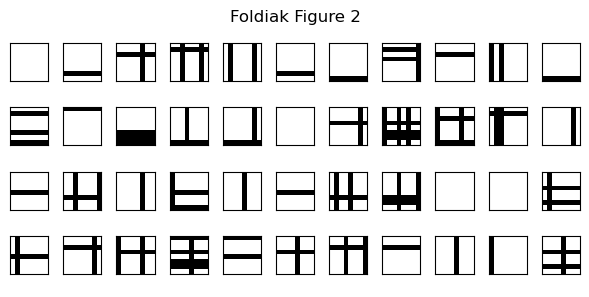

In [5]:
L1 = 8
L2 = 8
p1 = [1.0/L1]*L1
p2 = [1.0/L2]*L2
display_samples(L1, L2, p1, p2)

In [90]:
class FoldiakNetwork():
    def __init__(self, L1=8, L2=8, p1=[1/8.0]*8, p2=[1/8.0]*8):
        # i runs from 1 to n = len(y) = L1 + L2
        # j runs from 1 to m = len(x) = L1 * L2
        self.L1 = L1 # length of vertical side of input
        self.L2 = L2 # length of horizontal side of input
        self.y = np.zeros(self.L1 + self.L2) + 0.5 # output values
        self.q = rng.uniform(size=(self.L1 + self.L2,
                                   self.L1 * self.L2)) # q_ij connects xj to yi, shape len(y),len(x)
        # and normalize so sum_j((q_ij)**2)=1
        self.q = self.q / np.sqrt(np.sum(self.q**2, axis=1)).reshape((self.q.shape[0],1))
        self.w = np.zeros((self.L1 + self.L2, self.L1 + self.L2)) # w_ij connects yi to yj, shape len(y),len(y)
        self.t = np.zeros(self.L1 + self.L2) # t_i is the threshold for y_i, shape len(y)
        self.p1 = np.array(p1) # L1-length vector of probabilities of line being drawn from vertical axis
        self.p2 = np.array(p2) # L2-length vector of probabilities of line being drawn from horizontal axis
        self.p = np.matmul(self.p1.reshape((self.p1.shape[0],1)), self.p2.reshape((1,self.p2.shape[0])))
        
    def f(self, u, lam=20):
        return 1.0 / (1 + np.exp(-lam * u))
    
    def uTrans(self, im):
        return np.sum(self.q * im.reshape((1, im.shape[0])), axis=1) + \
               np.sum(self.w * self.y) - self.t
    
    def dy(self, im, lam=20, T=10):
        return (self.f(self.uTrans(im), lam) - self.y) / T
    
    def simTrans(self, im, lam=20, T=10):
        # T is the number of time steps to simulate
        for dt in range(int(T)):
            dy = self.dy(im, lam, T)
            self.y += dy
            ynorm = np.linalg.norm(self.y)
            if np.linalg.norm(dy) / (ynorm+1e-9) < 1/100000.0:
                break
        self.y = np.around(self.y)
        
    def hebbian(self, imj, i, j, beta=0.05):
        # imj is the value of the image at index j
        self.q[i,j] += beta * self.y[i] * (imj - self.q[i,j])
        self.q = self.q / np.sqrt(np.sum(self.q**2, axis=1)).reshape((self.q.shape[0],1))

    def antihebb(self, i, j, alpha=0.05):
        if i == j or self.w[i,j] > 0:
            self.w[i,j] = 0
        else:
            if i >= self.L1:
                pi = self.p2[i - self.L1]
            else:
                pi = self.p1[i]
            if j >= self.L1:
                pj = self.p2[j - self.L1]
            else:
                pj = self.p1[j]
            self.w[i,j] -= alpha * (self.y[i] * self.y[j] - pi*pj)

    def dthresh(self, i, gamma=0.2):
        if i >= self.L1:
            pi = self.p2[i - self.L1]
        else:
            pi = self.p1[i]
        self.t[i] += gamma * (self.y[i] - pi)
    
    def update(self, im, alpha=0.05, beta=0.05, gamma=0.2):
        for i in range(self.L1 + self.L2):
            for j in range(self.L1 * self.L2):
                self.hebbian(im[j], i, j, beta)
            for j in range(self.L1 + self.L2):
                self.antihebb(i, j, alpha)
            self.dthresh(i, gamma)
        
    def trial(self, im, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20):
        self.simTrans(im, lam, T)
        self.update(im, alpha, beta, gamma)
    
    def plot_q(self, fig, n_trial, row, n_rows):
        for i in range(self.L1 + self.L2):
            fig.add_subplot(n_rows, self.L1 + self.L2, row*(self.L1 + self.L2) + i+1)
            if i == 0:
                plt.ylabel(n_trial)
            plt.imshow(-1*self.q[i,:].reshape((self.L1, self.L2)),
                       cmap='Greys')
            plt.tick_params(left=False, right=False, top=False, bottom=False,
                            labelleft=False, labelright=False,
                            labeltop=False, labelbottom=False)
        return row + 1
    
    def train_lines(self, fig, n_rows=4, n_trials=1200, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20):
        row = 1
        for n in range(n_trials):
            im = gen_sample(self.L1, self.L2, self.p1, self.p2)
            self.trial(im, T, alpha, beta, gamma, lam)
            if n % 400 == 399:
                row = self.plot_q(fig, n+1, row, n_rows)
    
    def warmup_lines(self, n_warmup, T=10, alpha=0, beta=0, gamma=0.1, lam=10):
        for t in range(n_warmup):
            im = gen_sample(self.L1, self.L2, self.p1, self.p2)
            self.trial(im, T, alpha=0, beta=0, gamma=0.1, lam=10)
    
    def learn_lines(self, title, n_trials=1200, n_warmup=0, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20):
        self.warmup_lines(n_warmup, alpha=0, beta=0, gamma=0.1, lam=10)
        n_rows = int(n_trials / 400) + 1
        row = 0
        fig = plt.figure(figsize=(10,3))
        plt.title(title)
        plt.axis('off')
        row = self.plot_q(fig, n_trial=0, row=row, n_rows=n_rows)
        self.train_lines(fig, n_rows, n_trials, T, alpha, beta, gamma, lam)
        plt.show(fig)
    
    def learn_mnist(self, n_trials=1, n_warmup=0, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20):
        # Returns tuple of learned representations as (60000,56) and (10000,56) ndarrays
        train, test = pickle.load(open('mnist.pkl', 'rb'), encoding='bytes')
        trainx, trainy = train
        testx, testy = test
        trainx = trainx[:1000] / trainx.max()
        testx = testx[:200] / testx.max()
        for n in range(n_warmup):
            print(f'Warming Up {n+1}')
            order = rng.permutation(np.arange(len(trainx)))
            xn = trainx[order,:,:]
            for im in tqdm(xn):
                self.trial(im.flatten(), T, alpha=0, beta=0, gamma=0.1, lam=10)
        for n in range(n_trials):
            print(f'Doing Trial {n+1}')
            order = rng.permutation(np.arange(len(trainx)))
            xn = trainx[order,:,:]
            for im in tqdm(xn):
                self.trial(im.flatten(), T, alpha, beta, gamma, lam)
        train_reps = []
        print('Getting Training Representations')
        for im in tqdm(trainx):
            self.trial(im.flatten(), T, alpha, beta, gamma, lam)
            train_reps.append(self.y)
        test_reps = []
        print('Getting Testing Representations')
        for im in tqdm(testx):
            self.trial(im.flatten(), T, alpha, beta, gamma, lam)
            test_reps.append(self.y)
        print('Done!')
        return np.stack(train_reps), np.stack(test_reps)

    def pred_mnist(self, n_trials=1, n_warmup=0, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20):
        # Prints test accuracy on MNIST
        train, test = pickle.load(open('mnist.pkl', 'rb'), encoding='bytes')
        trainx, trainy = train
        testx, testy = test
        trainx = trainx[:1000] / trainx.max()
        testx = testx[:200] / testx.max()
        trainy = trainy[:1000]
        testy = testy[:200]
        train_reps, test_reps = self.learn_mnist(n_trials, n_warmup, T, alpha, beta, gamma, lam)
        logreg = LogisticRegression(penalty=None)
        logreg.fit(train_reps, trainy)
        print('Foldiak-trained MNIST Score:', logreg.score(test_reps, testy))

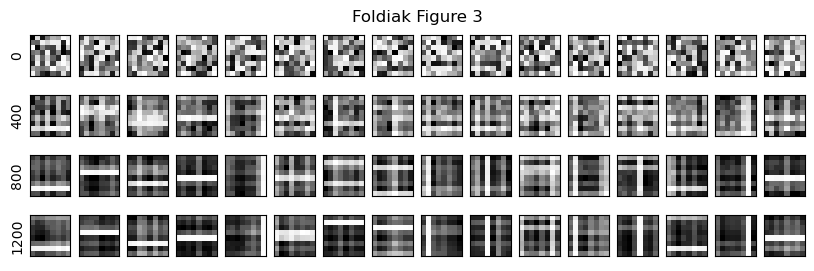

In [66]:
L1, L2, p1, p2 = (8, 8, [1/8.]*8, [1/8.]*8)
network = FoldiakNetwork(L1, L2, p1, p2)
network.learn_lines('Foldiak Figure 3',
                    n_trials=1200, n_warmup=100, T=100, alpha=0.1, beta=0.02, gamma=0.02, lam=10)

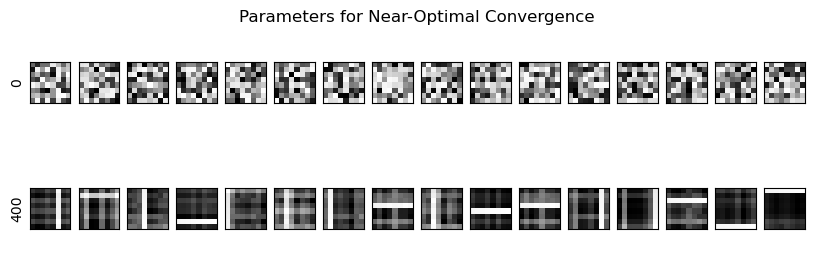

In [74]:
# Foldiak parameters for near optimal convergence speed
L1, L2, p1, p2 = (8, 8, [1/8.]*8, [1/8.]*8)
network = FoldiakNetwork(L1, L2, p1, p2)
network.learn_lines('Parameters for Near-Optimal Convergence',
                    n_trials=400, n_warmup=0, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20)

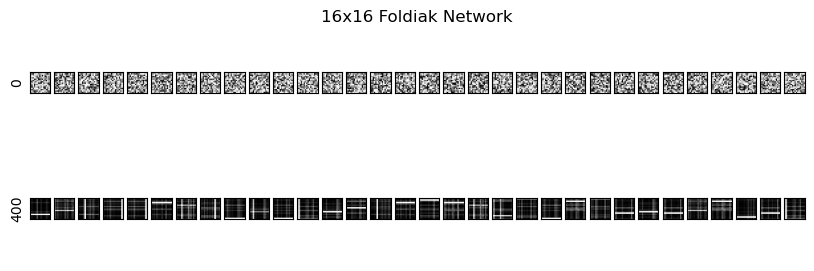

In [86]:
# Foldiak network with 16x16 grid
L1, L2, p1, p2 = (16, 16, [1/16.]*16, [1/16.]*16)
network = FoldiakNetwork(L1, L2, p1, p2)
network.learn_lines('16x16 Foldiak Network', 
                    n_trials=400, n_warmup=0, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20)

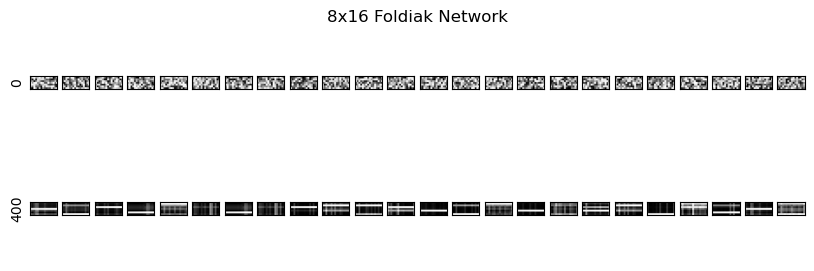

In [87]:
# Foldiak network with 8x16 grid
L1, L2, p1, p2 = (8, 16, [1/8.]*8, [1/16.]*16)
network = FoldiakNetwork(L1, L2, p1, p2)
network.learn_lines('8x16 Foldiak Network', 
                    n_trials=400, n_warmup=0, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20)

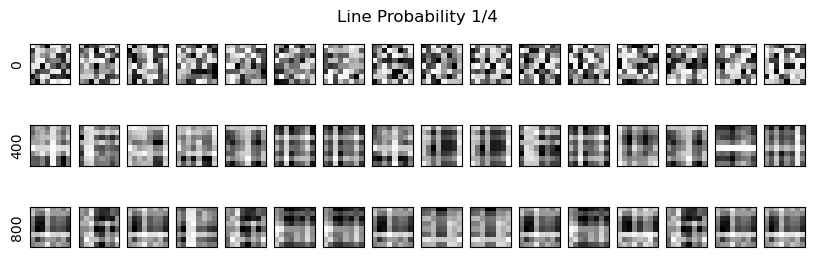

In [92]:
# Foldiak network with increased probabilities
L1, L2, p1, p2 = (8, 8, [1/4.]*8, [1/4.]*8)
network = FoldiakNetwork(L1, L2, p1, p2)
network.learn_lines('Line Probability 1/4', 
                    n_trials=800, n_warmup=0, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20)

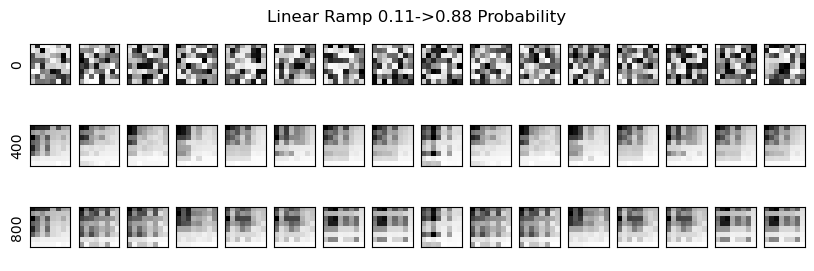

In [88]:
# Foldiak network with ramping probabilities
L1, L2, p1, p2 = (8, 8, (np.arange(9)/9)[1:].tolist(), (np.arange(9)/9)[1:].tolist())
network = FoldiakNetwork(L1, L2, p1, p2)
network.learn_lines('Linear Ramp 0.11->0.88 Probability', 
                    n_trials=800, n_warmup=0, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20)

In [91]:
# Predict on MNIST using Foldiak representations
mnist_network = FoldiakNetwork(28, 28, [1/28.0]*28, [1/28.0]*28)
mnist_network.pred_mnist(n_trials=3, n_warmup=0, T=10, alpha=0.05, beta=0.05, gamma=0.2, lam=20)

Doing Trial 1


100%|███████████████████████████████████████| 1000/1000 [55:53<00:00,  3.35s/it]


Doing Trial 2


100%|███████████████████████████████████████| 1000/1000 [56:00<00:00,  3.36s/it]


Doing Trial 3


100%|███████████████████████████████████████| 1000/1000 [56:05<00:00,  3.37s/it]


Getting Training Representations


100%|███████████████████████████████████████| 1000/1000 [55:46<00:00,  3.35s/it]


Getting Testing Representations


100%|█████████████████████████████████████████| 200/200 [11:11<00:00,  3.36s/it]

Done!
Foldiak-trained MNIST Score: 0.09


In [12]:
train, test = pickle.load(open('mnist.pkl', 'rb'), encoding='bytes')
trainx, trainy = train
testx, testy = test
trainx = trainx[:10000] / trainx.max()
testx = testx[:2000] / testx.max()
trainy = trainy[:10000]
testy = testy[:2000]

In [13]:
# Predict on MNIST using standard logistic regression
logreg = LogisticRegression(penalty=None)
logreg.fit(trainx.reshape((10000,28**2)), trainy)
print('Regular Logistic Regression Score:', logreg.score(testx.reshape((2000,28**2)), testy))

Regular Logistic Regression Score: 0.8495


In [57]:
# Create a basic CNN for image classification
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN,self).__init__()
        self.Conv = nn.Conv2d(1, 1, 3, padding='same')
        self.Pool = nn.MaxPool2d(2, 2)
        self.Lin  = nn.Linear(1*14*14, 10)

    def forward(self, x):
        x = self.Pool(F.relu((self.Conv(x))))
        x = self.Lin(x.flatten(start_dim=1))
        return F.softmax(x)

In [58]:
# Train the CNN
model = BasicCNN()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 3)

n_epochs = 12
model.train()
for epoch in range(n_epochs):
    train_loss = 0
    order = rng.permutation(np.arange(len(trainx)))
    xn = trainx[order,:,:]
    yn = trainy[order]
    n_batches = int(10000 / 50)
    for i in tqdm(range(n_batches)):
        ims = xn[i*50:(i+1)*50, :, :]
        output = model(torch.tensor(ims, dtype=torch.float)[:,None,:,:])
        loss = loss_fn(output, torch.tensor(yn[i*50:(i+1)*50]))
        train_loss += loss / xn.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1} Train Loss:', train_loss.detach().item())

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 465.16it/s]


Epoch 1 Train Loss: 2.018294095993042


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 496.80it/s]


Epoch 2 Train Loss: 1.6736501455307007


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 483.97it/s]


Epoch 3 Train Loss: 1.6170748472213745


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 505.26it/s]


Epoch 4 Train Loss: 1.5922285318374634


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 491.07it/s]


Epoch 5 Train Loss: 1.5779067277908325


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 498.62it/s]


Epoch 6 Train Loss: 1.5684329271316528


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 498.48it/s]


Epoch 7 Train Loss: 1.5618879795074463


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 495.56it/s]


Epoch 8 Train Loss: 1.557023048400879


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 495.70it/s]


Epoch 9 Train Loss: 1.5532472133636475


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 494.04it/s]


Epoch 10 Train Loss: 1.5492901802062988


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 491.45it/s]


Epoch 11 Train Loss: 1.5466704368591309


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 482.16it/s]

Epoch 12 Train Loss: 1.5440311431884766


In [59]:
# Evaluate the CNN performance
accuracy = 0
model.eval()
for idx, im in tqdm(enumerate(testx)):
    output = model(torch.tensor(im, dtype=torch.float)[None,None,:,:])
    pred = torch.argmax(output)
    accuracy += int(pred == testy[idx]) / testy.shape[0]
print('Basic CNN Score:', accuracy)

2000it [00:00, 5245.06it/s]

Basic CNN Score: 0.883999999999958
